In [1]:
import sys, os
sys.path.insert(0, '../..')
import tools.find_mxnet
import mxnet as mx
print mx

%matplotlib inline
from detect.detector import Detector
from symbol.symbol_factory import get_symbol

<module 'mxnet' from '/home/zhouji/mxnet_new_for_ssd/incubator-mxnet/example/ssd/tools/../../../python/mxnet/__init__.pyc'>


# Use office detect 

In [2]:
def get_detector(net, prefix, epoch, data_shape, mean_pixels, ctx, num_class, batch_size,
                 nms_thresh=0.5, force_nms=True, nms_topk=400):
    """
    wrapper for initialize a detector

    Parameters:
    ----------
    net : str
        test network name
    prefix : str
        load model prefix
    epoch : int
        load model epoch
    data_shape : int
        resize image shape
    mean_pixels : tuple (float, float, float)
        mean pixel values (R, G, B)
    ctx : mx.ctx
        running context, mx.cpu() or mx.gpu(?)
    num_class : int
        number of classes
    nms_thresh : float
        non-maximum suppression threshold
    force_nms : bool
        force suppress different categories
    """
    if net is not None:
        net = get_symbol(net, data_shape, num_classes=num_class, nms_thresh=nms_thresh,
            force_nms=force_nms, nms_topk=nms_topk)
    detector = Detector(net, prefix, epoch, data_shape, mean_pixels, batch_size=batch_size,ctx=ctx)
    return detector

def parse_class_names(class_names):
    """ parse # classes and class_names if applicable """
    if len(class_names) > 0:
        if os.path.isfile(class_names):
            # try to open it to read class names
            with open(class_names, 'r') as f:
                class_names = [l.strip() for l in f.readlines()]
        else:
            class_names = [c.strip() for c in class_names.split(',')]
        for name in class_names:
            assert len(name) > 0
    else:
        raise RuntimeError("No valid class_name provided...")
    return class_names



Detection time for 4 images: 0.1008 sec


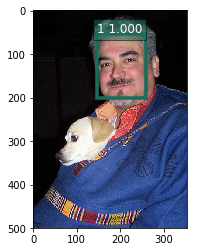

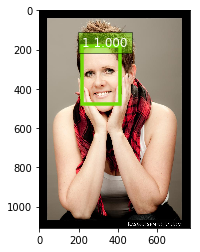

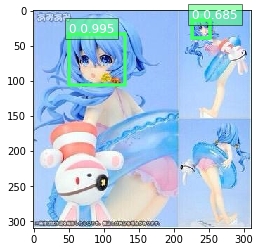

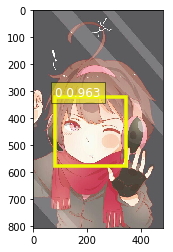

Detection time for 400 images: 21.0537 sec


In [3]:
if __name__ == '__main__':
    ctx = mx.gpu(5)

    # parse image list
    image_list = [
                 '/home/zhouji/mxnet_new_for_ssd/incubator-mxnet/example/ssd/data/demo/000001.jpg',
                 '/world/data-c5/faster_rcnn/aflw_data/VOCdevkit2007/VOC2007/JPEGImages/32546.jpg',
                 '/world/data-c8/wash/20160707/57450fce8bb96b1329e2469e/577a5840eb647f664e50b9ee/0/14528576107420.2580822170712054.jpg',
                 '/world/data-c8/wash/20160707/57450fce8bb96b1329e2469e/577a5840eb647f664e50b9ee/0/14528574012600.939023926621303.jpg'
                 ]

    network = 'vgg16_reduced'
    prefix = './model/new_train_model_tupu_face/vgg16_reduced/ssd_vgg16_reduced_300'
    epoch = 50
    data_shape = 300
    class_names = '0,1'
    batch_size = 1
    class_names = parse_class_names(class_names)
    
    detector = get_detector(network, prefix, epoch,
                            data_shape,
                            (123, 117, 104),
                            ctx, len(class_names), batch_size, 0.5, True)
    # run detection 
    detector.detect_and_visualize(image_list, '', '',
                                  class_names, 0.5, True)
    
    
    # repeat test image list 100 
    rets = detector.im_detect(image_list*100, '', '', show_timer=True)
    #print (rets)

# Use ssd_mxnet_engine in tpdedect 

[MXNET_SSD] data len: 4
Detection time for 4 images: 0.0794 sec


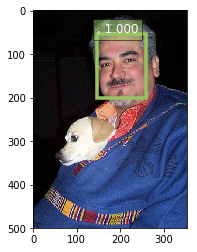

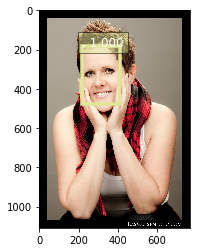

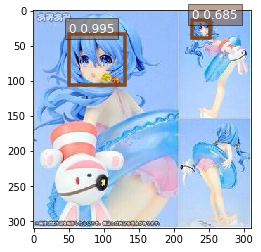

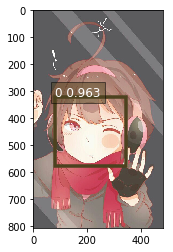

[MXNET_SSD] data len: 400
Detection time for 400 images: 14.3150 sec


In [4]:
import sys
sys.path.insert(0, '/home/zhouji/tp_server/tpdetect/ssd')
import mxnet_engine
import mxnet as mx
import cv2
import time
import numpy as np


image_list = [
             '/home/zhouji/mxnet_new_for_ssd/incubator-mxnet/example/ssd/data/demo/000001.jpg',
             '/world/data-c5/faster_rcnn/aflw_data/VOCdevkit2007/VOC2007/JPEGImages/32546.jpg',
             '/world/data-c8/wash/20160707/57450fce8bb96b1329e2469e/577a5840eb647f664e50b9ee/0/14528576107420.2580822170712054.jpg',
             '/world/data-c8/wash/20160707/57450fce8bb96b1329e2469e/577a5840eb647f664e50b9ee/0/14528574012600.939023926621303.jpg'
             ]

symbol = None
network_name = 'vgg16_reduced'
prefix = '/home/zhouji/mxnet_new_for_ssd/incubator-mxnet/example/ssd/model/new_train_model_tupu_face/vgg16_reduced/ssd_vgg16_reduced_300'
epoch = 50
data_shape = 300
mean_pixels = (123, 117, 104)
class_names = '0,1'
batch_size = 1
gid = 3
#class_names = parse_class_names(class_names)

engine = mxnet_engine.MxnetSSDEngine(symbol, network_name, prefix, epoch, data_shape, mean_pixels, batch_size, gid)
engine.use_batch_detect = True
print engine
# detect use office method
#res = engine.detect_bk(image_list, '', '', show_timer=True)
#print('old code ', res)


# detect and show result
engine.detect_and_visualize(image_list, '', '',
                            class_names, 0.5, True)

datas = []
for im in image_list*100:
    data = cv2.imread(im, cv2.IMREAD_COLOR)
    #data = cv2.resize(data, (300, 300))
    #data = cv2.imencode('.jpg', data)[1]
    #data[:, :, (0, 1, 2)] = data[:, :, (2, 1, 0z)]
    datas.append(data)

res = engine.detect(datas, '', '', show_timer=True)
#print('new result ', res)


# Use ssd_mxnet_engine (inceptionv3) in tpdedect

[MXNET_SSD] data len: 1
Detection time for 1 images: 0.0499 sec


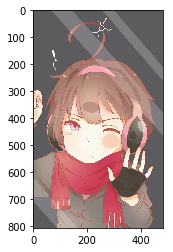

[MXNET_SSD] data len: 1
Detection time for 1 images: 0.0256 sec


In [5]:
import sys
sys.path.insert(0, '/home/zhouji/tp_server/tpdetect/ssd')
import mxnet_engine
import mxnet as mx
import cv2
import time
import numpy as np


image_list = [
             #'/home/zhouji/mxnet_new_for_ssd/incubator-mxnet/example/ssd/data/demo/000001.jpg',
             #'/world/data-c5/faster_rcnn/aflw_data/VOCdevkit2007/VOC2007/JPEGImages/32546.jpg',
             #'/world/data-c8/wash/20160707/57450fce8bb96b1329e2469e/577a5840eb647f664e50b9ee/0/14528576107420.2580822170712054.jpg',
             '/world/data-c8/wash/20160707/57450fce8bb96b1329e2469e/577a5840eb647f664e50b9ee/0/14528574012600.939023926621303.jpg'
             ]

symbol = None
network_name = 'inceptionv3'
prefix = '/home/zhouji/mxnet_new_for_ssd/incubator-mxnet/example/ssd/model/new_train_model_tupu_face/inceptionv3/ssd_inceptionv3_300'
epoch = 50
data_shape = 300
mean_pixels = (123, 117, 104)
class_names = '0,1'
batch_size = 1
gid = 3
#class_names = parse_class_names(class_names)

engine = mxnet_engine.MxnetSSDEngine(symbol, network_name, prefix, epoch, data_shape, mean_pixels, batch_size, gid)
engine.use_batch_detect = True
print engine
# detect use office method
#res = engine.detect_bk(image_list, '', '', show_timer=True)
#print('old code ', res)


# detect and show result
engine.detect_and_visualize(image_list, '', '',
                            class_names, 0.5, True)

datas = []
for im in image_list*1:
    data = cv2.imread(im, cv2.IMREAD_COLOR)
    #data = cv2.resize(data, (300, 300))
    #data = cv2.imencode('.jpg', data)[1]
    #data[:, :, (0, 1, 2)] = data[:, :, (2, 1, 0z)]
    datas.append(data)

res = engine.detect(datas, '', '', show_timer=True)
#print('new result ', res)

# Test speed

In [ ]:
import time
def check_speed(sym, ctx, scale=1.0, N=1000):
    exe = sym.simple_bind(grad_req='write', **ctx)
    _, arg_params, aux_params = mx.model.load_checkpoint(
        './model/new_train_model_tupu_face/vgg16_reduced/ssd_vgg16_reduced_300', 8)
    # init = [np.random.normal(size=arr.shape, scale=scale) for arr in exe.arg_arrays]
    # for arr, iarr in zip(exe.arg_arrays, arg_params):
    #     arr[:] = iarr.astype(arr.dtype)
    exe.copy_params_from(arg_params, aux_params)

    exe.forward(is_train=False)
    exe.outputs[0].wait_to_read()

    tic = time.time()
    for i in range(N):
        t = time.time()
        exe.forward(is_train=False)
        exe.outputs[0].wait_to_read()
    print 'total time: ', time.time() - tic, 'FPS: ', N/(time.time() - tic)
    return (time.time() - tic)*1.0/N

ctx_list = [{'ctx': mx.gpu(1), 'data': (1, 3, 300, 300)}]

#sym = get_symbol(num_classes=20, nms_thresh=0.5, force_suppress=True)
sym = get_symbol('vgg16_reduced', 300, num_classes=2,nms_thresh=0.5, force_nms=True, nms_topk=400)

for ctx in ctx_list:
    print ctx
    print check_speed(sym, ctx, N=100), 's/img'
